In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import datetime
from datetime import timedelta
import random
import m5forecasting as m5
import matplotlib.pyplot as plt

In [10]:
df = m5.df
all_data = m5.all_data

In [46]:
# rolling = [[2,3,4], [1,3,5], [1,2]]
# start_day = 1913
# end_day = 1913
# num_days = end_day - start_day + 1
# total_entries = num_days * 30490
# # rolling lag features
# count = 0
# temp_training = np.zeros((total_entries, len(rolling)))
# for time_series_idx in range(30490):
#     for i in range(end_day - num_days,end_day):
#         temp_training[count] = [all_data[time_series_idx, [i - lag for lag in rolling_lags]].sum() / len(rolling_lags) 
#                                 for rolling_lags in rolling]
#         count += 1

## Feature Generation

In [43]:
total_entries = 30490 * 5
temp_training = np.floor(np.arange(total_entries) / 5).reshape((total_entries, 1))
categoricalfeatures.append(1)

NameError: name 'categoricalfeatures' is not defined

In [16]:
3 + 3

6

In [12]:
def getYearMonthDay(day):
    temp = datetime(2011,1,28) + timedelta(days=day)
    return [temp.year, temp.month, temp.day]

def getDay(day):
    temp = day % 7
    return [temp, int(temp > 0 and temp < 3)]

def getSnapValue(day, state_index):
    return int(m5.calendar[m5.calendar.d == "d_" + str(day)].iloc[:, 11 + state_index])

# item number, item department, item category, store, state
departmentInt = {}
current_id = "HOBBIES_1"
count = 0
for i in range(3049):
    if df.iloc[i]["dept_id"] != current_id or i == 3048:
        departmentInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["dept_id"]

categoryInt = {}
current_id = "HOBBIES"
count = 0
for i in range(3049):
    if df.iloc[i]["cat_id"] != current_id or i == 3048:
        categoryInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["cat_id"]

storeInt = {}
current_id = "CA_1"
count = 0
for i in range(0,30490,3049):
    if df.iloc[i]["store_id"] != current_id:
        storeInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["store_id"]
        storeInt[current_id] = count

stateInt = {}
current_id = "CA"
count = 0
for i in range(0,30490,3049):
    if df.iloc[i]["state_id"] != current_id:
        stateInt[current_id] = count
        count += 1
        current_id = df.iloc[i]["state_id"]
        stateInt[current_id] = count

def generateTrainingData(start_day, end_day, lags, rolling, all_data, withLabels = True, verbose=False):
    num_days = end_day - start_day + 1
    num_series = 30490
    total_entries = num_days * num_series
    training_data = np.zeros((total_entries, len(lags)))
    categoricalfeatures = [0] * len(lags)
    maxBinByFeature = [255] * len(lags)
    if withLabels:
        training_labels = np.zeros(total_entries)
    
    # lag features
    count = 0
    for time_series_idx in range(30490):
        for i in range(end_day - num_days,end_day):
            training_data[count] = all_data[time_series_idx, [i - lag for lag in lags]]
            if withLabels:
                training_labels[count] = all_data[time_series_idx, i]
            count += 1
    
    if verbose:
        print("Finished lag features")
    
    # rolling lag features
    count = 0
    categoricalfeatures.extend([0] * len(rolling))
    maxBinByFeature.extend([255] * len(rolling))
    temp_training = np.zeros((total_entries, len(rolling)))
    for time_series_idx in range(30490):
        for i in range(end_day - num_days,end_day):
            temp_training[count] = [all_data[time_series_idx, [i - lag for lag in rolling_lags]].sum() / len(rolling_lags) for rolling_lags in rolling]
            count += 1
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished rolling lag features")
    
    # item features - item number, department, category, store, state
    temp_training = np.zeros((total_entries, 5))
    categoricalfeatures.extend([1] * 5)
    maxBinByFeature.extend([3049, 7, 3, 10, 3])
    for i in range(0, total_entries, num_days):
        item_number = i // num_days % 3049
        temp_training[i:i + num_days, 0] = item_number
        temp_training[i:i + num_days, 1] = departmentInt[df["dept_id"].iloc[item_number]]
        temp_training[i:i + num_days, 2] = categoryInt[df["cat_id"].iloc[item_number]]
        temp_training[i:i + num_days, 3] = storeInt[df["store_id"].iloc[i // num_days]]
        temp_training[i:i + num_days, 4] = stateInt[df["state_id"].iloc[i // num_days]]
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished item features")
    
    # snap feature
    temp_training = np.zeros((total_entries, 1))
    categoricalfeatures.append(1)
    maxBinByFeature.append(2)
    for idx, day in enumerate(range(start_day, end_day + 1)):
        temp_training[range(idx, idx + 3049 * 4 * num_days, num_days), 0] = getSnapValue(day, 0)
        temp_training[range(idx + 3049 * 4 * num_days, idx + 3049 * 7 * num_days, num_days), 0] = getSnapValue(day, 1)
        temp_training[range(idx + 3049 * 7 * num_days, idx + 3049 * 10 * num_days, num_days), 0] = getSnapValue(day, 2)
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    # year, month, day
    temp_training = np.zeros((total_entries, 3))
    categoricalfeatures.extend([1] * 3)
    maxBinByFeature.extend([5, 12, 31])
    for i in range(total_entries):
        temp_training[i] = getYearMonthDay(i % num_days + (end_day + 1 - num_days))
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished date features")
    
    # day of week and is weekend
    temp_training = np.zeros((total_entries, 2))
    categoricalfeatures.extend([1] * 2)
    maxBinByFeature.extend([7, 2])
    for i in range(total_entries):
        temp_training[i] = getDay(i % num_days + (end_day + 1 - num_days))
    training_data = np.concatenate((training_data, temp_training), axis=1)
    
    if verbose:
        print("Finished day features")
    
    if withLabels:
        return training_data, training_labels, [idx for idx, val in enumerate(categoricalfeatures) if val == 1], maxBinByFeature
    else:
        return training_data

## Model Training / Testing

In [4]:
def custom_asymmetric_train(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2.0 * residual, -2 * residual * 1.15)
    hess = np.where(residual < 0, 2.0, 2.0 * 1.15)
    return grad, hess

def custom_asymmetric_valid(y_pred, y_true):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

In [5]:
def Level_12_WRMSSE(y_pred, y_true):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float")
    diff_squared = (diff * diff).reshape((30490, 28))
    return "Lev 12", np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[12] / 12.0), False

def Level_1_WRMSSE(y_pred, y_true):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    diff_squared = np.square(m5.transformer[1](diff))
    return "Lev 1", np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[1] / 12.0), False

In [391]:
def Level_1_12_WRMSSE(y_pred, y_true):
    response1 = Level_1_WRMSSE(y_pred, y_true)
    response12 = Level_12_WRMSSE(y_pred, y_true)
    return "Lev 1: {} Lev 12:".format(response1[1]), response12[1], False

## Ignore Above

Data
- SNAP data
- weather data
- rolling averages
- seasonal data
- prices?

Custom Loss
- Independent gradients with RMSE and weights
- Dependent gradients - group by time series and group by day
- Various levels

In [13]:
def byLevelWRMSSE(y_pred, y_true, level):
    y_true = y_true.get_label()
    diff = (y_true - y_pred).astype("float").reshape((30490, 28))
    if level > 0:
        diff_squared = np.square(m5.transformer[level](diff))
        return "Lev {}".format(level), np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[level] / 12.0), False
    else:
        total_loss = 0.0
        for i in range(1,13):
            diff_squared = np.square(m5.transformer[i](diff))
            total_loss += np.sum(np.sqrt(np.sum(diff_squared, axis = 1)) * m5.weights[i] / 12.0)
        return "WRMSSE", total_loss, False

In [48]:
minWeight = min([i for i in m5.weights[12] if i != 0])
maximum = m5.weights[12].max()
def level12Weighted(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    for i in range(30490): 
        residual[i * num_days:(i+1) * num_days] = max(minWeight, m5.weights[12][i]) / maximum * residual[i * num_days:(i+1) * num_days]
    grad = -5.0 * residual
    hess = 5.0 * np.ones(residual.shape)
    return grad, hess

In [8]:
def groupByDay(y_pred, y_true):
    y_true = y_true.get_label()
    num_days = int(len(y_pred) / 30490)
    residual = (y_true - y_pred).astype("float")
    grad = np.zeros(y_pred.shape)
    hess = np.zeros(y_pred.shape)
    for i in range(num_days):
        all_series = residual[range(i, total, num_days)]
        grad[range(i, total, num_days)] -= all_series.sum() / (30490 * 2.0)
    return grad, hess

In [10]:
def combined1(y_pred, y_true):
    l12grad, l12hess = level12Weighted(y_pred, y_true)
    groupgrad, grouphess = groupByDay(y_pred, y_true)
    return l12grad + groupgrad, l12hess + grouphess

In [11]:
def groupByTimeSeries():
    # put all data from one time series under one sqrt so that it affects the gradient
    for i in range(30490):
        residual[i * num_days: (i+1) * num_days]

In [12]:
def expandWeights(weight, days):
    new_weights = np.zeros(len(weight) * days)
    for i in range(days):
        new_weights[range(i, len(new_weights), days)] = weight
    return new_weights

In [17]:
%%time
lags = list(range(7, 15, 7)) + list(range(15, 40, 1))
rolling = [range(1,15), range(4,11), range(7,14), range(28, 28 * 6, 28)]
start_day = 1200
end_day = 1885
num_train_days = end_day - start_day + 1
num_val_days = 1913 - end_day + 1
training_data, training_labels, categories, maxBinByFeature = generateTrainingData(start_day, end_day, lags, rolling, all_data, verbose=True)
val_data, val_labels, _, _ = generateTrainingData(end_day + 1, 1913, lags, rolling, all_data, verbose=True)

Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
Finished lag features
Finished rolling lag features
Finished item features
Finished date features
Finished day features
Wall time: 20min 14s


In [18]:
training_dataset = lgb.Dataset(training_data, 
                               label=training_labels, 
                               free_raw_data=False)
val_dataset = lgb.Dataset(val_data,
                          label=val_labels, 
                          free_raw_data=False, 
                          reference=training_dataset)

In [3]:
lags

NameError: name 'lags' is not defined

In [22]:
# %% time
# np.save("features/training_data.npy", training_data)
# np.save("features/training_labels.npy", training_labels)
# np.save("features/categories.npy", categories)
# np.save("features/val_data.npy", val_data)
# np.save("features/val_labels.npy", val_labels)

In [23]:
%%time
# training_data = np.load("features/training_data.npy").astype("float")
# training_labels = np.load("features/training_labels.npy").astype("float")
categories = list(np.load("features/categories.npy").astype("int"))
# val_data = np.load("features/val_data.npy").astype("float")
# val_labels = np.load("features/val_labels.npy").astype("float")

Wall time: 1.99 ms


In [55]:
params = {
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'seed': 42,
    'bagging_fraction': 0.2,
    'bagging_freq': 2, 
    'colsample_bytree': 0.95,
    'colsample_bynode': 0.5,
    'num_leaves': 1000,
    'lambda_l1': 0.2,
    'lambda_l2': 0.2,
    'metric': "None",
    'max_bin_by_feature ': maxBinByFeature,
    'first_metric_only': True
}

def learningRate(num_round):
    return 0.08 + 0.01 * num_round / 500

In [56]:
%%time
model = lgb.train(params, 
                  training_dataset, 
                  categorical_feature=categories, 
                  num_boost_round=4000,
                  valid_sets = [val_dataset],
                  fobj=level12Weighted,
                  feval = lambda y_pred, y_true: [byLevelWRMSSE(y_pred, y_true, level) for level in [0, 1, 6, 12]],
                  early_stopping_rounds=100,
                  verbose_eval=3,
                  learning_rates=learningRate
                 )

C:\Users\RMittal\anaconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1294: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
  warnings.warn('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
[3]	valid_0's WRMSSE: 5.21324	valid_0's Lev 1: 0.5948	valid_0's Lev 6: 0.515857	valid_0's Lev 12: 0.119766
[6]	valid_0's WRMSSE: 5.14093	valid_0's Lev 1: 0.587111	valid_0's Lev 6: 0.509162	valid_0's Lev 12: 0.117489
[9]	valid_0's WRMSSE: 5.0712	valid_0's Lev 1: 0.579624	valid_0's Lev 6: 0.502671	valid_0's Lev 12: 0.115402
[12]	valid_0's WRMSSE: 5.00429	valid_0's Lev 1: 0.572354	valid_0's Lev 6: 0.496386	valid_0's Lev 12: 0.113546
[15]	valid_0's WRMSSE: 4.93906	valid_0's Lev 1: 0.565243	valid_0's Lev 6: 0.490244	valid_0's Lev 12: 0.11178
[18]	valid_0's WRMSSE: 4.87648	valid_0's Lev 1: 0.558362	valid_0's Lev 6: 0.484309	valid_0's Lev 12: 0.110189
[21]	valid_0's WRMSSE: 4.81535	valid_0's Lev 1: 0.551595	valid_0's Lev 6: 0.478489	valid_0's Lev 12: 0.10869
[24]	valid_0's WRMSSE: 4.75633	valid_0's Lev 1: 0.545027	valid_0's Lev 6: 0.472831	valid_0's Lev 12: 0.107328
[27]	valid_0's WRMSSE: 4.69917	valid_0's Lev 1: 0.538625	valid_0's

[225]	valid_0's WRMSSE: 2.52976	valid_0's Lev 1: 0.283097	valid_0's Lev 6: 0.249192	valid_0's Lev 12: 0.077147
[228]	valid_0's WRMSSE: 2.50996	valid_0's Lev 1: 0.280695	valid_0's Lev 6: 0.24714	valid_0's Lev 12: 0.0769939
[231]	valid_0's WRMSSE: 2.49052	valid_0's Lev 1: 0.278338	valid_0's Lev 6: 0.245128	valid_0's Lev 12: 0.0768442
[234]	valid_0's WRMSSE: 2.47142	valid_0's Lev 1: 0.276021	valid_0's Lev 6: 0.243153	valid_0's Lev 12: 0.0766941
[237]	valid_0's WRMSSE: 2.45257	valid_0's Lev 1: 0.273734	valid_0's Lev 6: 0.241205	valid_0's Lev 12: 0.0765456
[240]	valid_0's WRMSSE: 2.43382	valid_0's Lev 1: 0.271454	valid_0's Lev 6: 0.239262	valid_0's Lev 12: 0.0764068
[243]	valid_0's WRMSSE: 2.41524	valid_0's Lev 1: 0.269197	valid_0's Lev 6: 0.237336	valid_0's Lev 12: 0.0762666
[246]	valid_0's WRMSSE: 2.39691	valid_0's Lev 1: 0.266968	valid_0's Lev 6: 0.235434	valid_0's Lev 12: 0.0761292
[249]	valid_0's WRMSSE: 2.37895	valid_0's Lev 1: 0.264786	valid_0's Lev 6: 0.233572	valid_0's Lev 12: 0.07

[447]	valid_0's WRMSSE: 1.5529	valid_0's Lev 1: 0.162846	valid_0's Lev 6: 0.146912	valid_0's Lev 12: 0.0714247
[450]	valid_0's WRMSSE: 1.5443	valid_0's Lev 1: 0.161771	valid_0's Lev 6: 0.146002	valid_0's Lev 12: 0.0713898
[453]	valid_0's WRMSSE: 1.53599	valid_0's Lev 1: 0.160733	valid_0's Lev 6: 0.145123	valid_0's Lev 12: 0.0713502
[456]	valid_0's WRMSSE: 1.52751	valid_0's Lev 1: 0.159666	valid_0's Lev 6: 0.14422	valid_0's Lev 12: 0.0713198
[459]	valid_0's WRMSSE: 1.51917	valid_0's Lev 1: 0.158617	valid_0's Lev 6: 0.143337	valid_0's Lev 12: 0.0712836
[462]	valid_0's WRMSSE: 1.51105	valid_0's Lev 1: 0.157595	valid_0's Lev 6: 0.142475	valid_0's Lev 12: 0.0712509
[465]	valid_0's WRMSSE: 1.50298	valid_0's Lev 1: 0.156578	valid_0's Lev 6: 0.141618	valid_0's Lev 12: 0.071217
[468]	valid_0's WRMSSE: 1.49512	valid_0's Lev 1: 0.155587	valid_0's Lev 6: 0.140786	valid_0's Lev 12: 0.0711858
[471]	valid_0's WRMSSE: 1.4873	valid_0's Lev 1: 0.154598	valid_0's Lev 6: 0.139955	valid_0's Lev 12: 0.07115

[669]	valid_0's WRMSSE: 1.11299	valid_0's Lev 1: 0.106613	valid_0's Lev 6: 0.0999019	valid_0's Lev 12: 0.0700227
[672]	valid_0's WRMSSE: 1.10909	valid_0's Lev 1: 0.106101	valid_0's Lev 6: 0.0994819	valid_0's Lev 12: 0.0700128
[675]	valid_0's WRMSSE: 1.10517	valid_0's Lev 1: 0.105589	valid_0's Lev 6: 0.0990602	valid_0's Lev 12: 0.0699992
[678]	valid_0's WRMSSE: 1.10133	valid_0's Lev 1: 0.105086	valid_0's Lev 6: 0.0986474	valid_0's Lev 12: 0.0699857
[681]	valid_0's WRMSSE: 1.09739	valid_0's Lev 1: 0.104568	valid_0's Lev 6: 0.0982223	valid_0's Lev 12: 0.0699792
[684]	valid_0's WRMSSE: 1.09363	valid_0's Lev 1: 0.104076	valid_0's Lev 6: 0.0978159	valid_0's Lev 12: 0.069971
[687]	valid_0's WRMSSE: 1.08966	valid_0's Lev 1: 0.103558	valid_0's Lev 6: 0.0973882	valid_0's Lev 12: 0.0699605
[690]	valid_0's WRMSSE: 1.08578	valid_0's Lev 1: 0.10305	valid_0's Lev 6: 0.0969712	valid_0's Lev 12: 0.0699502
[693]	valid_0's WRMSSE: 1.08211	valid_0's Lev 1: 0.102569	valid_0's Lev 6: 0.0965759	valid_0's Lev

[885]	valid_0's WRMSSE: 0.901866	valid_0's Lev 1: 0.0784276	valid_0's Lev 6: 0.0770998	valid_0's Lev 12: 0.0695929
[888]	valid_0's WRMSSE: 0.899562	valid_0's Lev 1: 0.0781157	valid_0's Lev 6: 0.0768507	valid_0's Lev 12: 0.0695846
[891]	valid_0's WRMSSE: 0.897362	valid_0's Lev 1: 0.0778121	valid_0's Lev 6: 0.0766096	valid_0's Lev 12: 0.069587
[894]	valid_0's WRMSSE: 0.895238	valid_0's Lev 1: 0.0775187	valid_0's Lev 6: 0.0763777	valid_0's Lev 12: 0.0695866
[897]	valid_0's WRMSSE: 0.893232	valid_0's Lev 1: 0.0772417	valid_0's Lev 6: 0.0761608	valid_0's Lev 12: 0.0695857
[900]	valid_0's WRMSSE: 0.89131	valid_0's Lev 1: 0.0769793	valid_0's Lev 6: 0.0759536	valid_0's Lev 12: 0.0695816
[903]	valid_0's WRMSSE: 0.889336	valid_0's Lev 1: 0.0767059	valid_0's Lev 6: 0.0757396	valid_0's Lev 12: 0.0695791
[906]	valid_0's WRMSSE: 0.887331	valid_0's Lev 1: 0.0764282	valid_0's Lev 6: 0.0755234	valid_0's Lev 12: 0.0695752
[909]	valid_0's WRMSSE: 0.885324	valid_0's Lev 1: 0.0761558	valid_0's Lev 6: 0.075

[1101]	valid_0's WRMSSE: 0.787715	valid_0's Lev 1: 0.0625019	valid_0's Lev 6: 0.0647804	valid_0's Lev 12: 0.0694545
[1104]	valid_0's WRMSSE: 0.786543	valid_0's Lev 1: 0.0623307	valid_0's Lev 6: 0.0646523	valid_0's Lev 12: 0.0694573
[1107]	valid_0's WRMSSE: 0.785251	valid_0's Lev 1: 0.0621472	valid_0's Lev 6: 0.0645129	valid_0's Lev 12: 0.0694567
[1110]	valid_0's WRMSSE: 0.784035	valid_0's Lev 1: 0.0619677	valid_0's Lev 6: 0.0643818	valid_0's Lev 12: 0.0694568
[1113]	valid_0's WRMSSE: 0.782856	valid_0's Lev 1: 0.0617998	valid_0's Lev 6: 0.0642559	valid_0's Lev 12: 0.069453
[1116]	valid_0's WRMSSE: 0.781773	valid_0's Lev 1: 0.0616466	valid_0's Lev 6: 0.0641388	valid_0's Lev 12: 0.0694522
[1119]	valid_0's WRMSSE: 0.780528	valid_0's Lev 1: 0.0614699	valid_0's Lev 6: 0.0640055	valid_0's Lev 12: 0.0694517
[1122]	valid_0's WRMSSE: 0.7793	valid_0's Lev 1: 0.0612937	valid_0's Lev 6: 0.0638754	valid_0's Lev 12: 0.06945
[1125]	valid_0's WRMSSE: 0.77821	valid_0's Lev 1: 0.0611364	valid_0's Lev 6: 

[1314]	valid_0's WRMSSE: 0.720933	valid_0's Lev 1: 0.0528225	valid_0's Lev 6: 0.0576011	valid_0's Lev 12: 0.0694182
[1317]	valid_0's WRMSSE: 0.720242	valid_0's Lev 1: 0.0527177	valid_0's Lev 6: 0.057526	valid_0's Lev 12: 0.0694192
[1320]	valid_0's WRMSSE: 0.719319	valid_0's Lev 1: 0.0525921	valid_0's Lev 6: 0.0574268	valid_0's Lev 12: 0.0694166
[1323]	valid_0's WRMSSE: 0.71856	valid_0's Lev 1: 0.0524782	valid_0's Lev 6: 0.0573465	valid_0's Lev 12: 0.0694161
[1326]	valid_0's WRMSSE: 0.717772	valid_0's Lev 1: 0.0523611	valid_0's Lev 6: 0.0572619	valid_0's Lev 12: 0.0694152
[1329]	valid_0's WRMSSE: 0.717073	valid_0's Lev 1: 0.052259	valid_0's Lev 6: 0.0571894	valid_0's Lev 12: 0.0694144
[1332]	valid_0's WRMSSE: 0.716344	valid_0's Lev 1: 0.0521483	valid_0's Lev 6: 0.0571119	valid_0's Lev 12: 0.0694137
[1335]	valid_0's WRMSSE: 0.715559	valid_0's Lev 1: 0.0520301	valid_0's Lev 6: 0.0570295	valid_0's Lev 12: 0.069415
[1338]	valid_0's WRMSSE: 0.71489	valid_0's Lev 1: 0.0519274	valid_0's Lev 6:

[1527]	valid_0's WRMSSE: 0.676629	valid_0's Lev 1: 0.0462284	valid_0's Lev 6: 0.0528382	valid_0's Lev 12: 0.0693901
[1530]	valid_0's WRMSSE: 0.676213	valid_0's Lev 1: 0.0461646	valid_0's Lev 6: 0.0527927	valid_0's Lev 12: 0.0693903
[1533]	valid_0's WRMSSE: 0.675482	valid_0's Lev 1: 0.0460539	valid_0's Lev 6: 0.0527145	valid_0's Lev 12: 0.0693895
[1536]	valid_0's WRMSSE: 0.675085	valid_0's Lev 1: 0.0459953	valid_0's Lev 6: 0.0526715	valid_0's Lev 12: 0.06939
[1539]	valid_0's WRMSSE: 0.674629	valid_0's Lev 1: 0.0459265	valid_0's Lev 6: 0.0526203	valid_0's Lev 12: 0.0693893
[1542]	valid_0's WRMSSE: 0.674127	valid_0's Lev 1: 0.0458529	valid_0's Lev 6: 0.0525674	valid_0's Lev 12: 0.0693901
[1545]	valid_0's WRMSSE: 0.67365	valid_0's Lev 1: 0.0457848	valid_0's Lev 6: 0.0525161	valid_0's Lev 12: 0.0693902
[1548]	valid_0's WRMSSE: 0.673068	valid_0's Lev 1: 0.0456901	valid_0's Lev 6: 0.0524535	valid_0's Lev 12: 0.069389
[1551]	valid_0's WRMSSE: 0.672723	valid_0's Lev 1: 0.0456345	valid_0's Lev 6

[1740]	valid_0's WRMSSE: 0.646455	valid_0's Lev 1: 0.0416345	valid_0's Lev 6: 0.0495785	valid_0's Lev 12: 0.0693849
[1743]	valid_0's WRMSSE: 0.646248	valid_0's Lev 1: 0.0416023	valid_0's Lev 6: 0.0495546	valid_0's Lev 12: 0.0693848
[1746]	valid_0's WRMSSE: 0.646008	valid_0's Lev 1: 0.0415679	valid_0's Lev 6: 0.0495269	valid_0's Lev 12: 0.0693842
[1749]	valid_0's WRMSSE: 0.645618	valid_0's Lev 1: 0.0415003	valid_0's Lev 6: 0.0494846	valid_0's Lev 12: 0.069385
[1752]	valid_0's WRMSSE: 0.645308	valid_0's Lev 1: 0.0414524	valid_0's Lev 6: 0.0494544	valid_0's Lev 12: 0.0693844
[1755]	valid_0's WRMSSE: 0.644729	valid_0's Lev 1: 0.0413602	valid_0's Lev 6: 0.0493918	valid_0's Lev 12: 0.0693853
[1758]	valid_0's WRMSSE: 0.64448	valid_0's Lev 1: 0.0413191	valid_0's Lev 6: 0.0493659	valid_0's Lev 12: 0.0693862
[1761]	valid_0's WRMSSE: 0.644097	valid_0's Lev 1: 0.0412695	valid_0's Lev 6: 0.0493247	valid_0's Lev 12: 0.0693847
[1764]	valid_0's WRMSSE: 0.643809	valid_0's Lev 1: 0.0412251	valid_0's Lev

[1953]	valid_0's WRMSSE: 0.625978	valid_0's Lev 1: 0.0385444	valid_0's Lev 6: 0.0473603	valid_0's Lev 12: 0.0693733
[1956]	valid_0's WRMSSE: 0.625525	valid_0's Lev 1: 0.0384722	valid_0's Lev 6: 0.0473122	valid_0's Lev 12: 0.069373
[1959]	valid_0's WRMSSE: 0.625294	valid_0's Lev 1: 0.0384401	valid_0's Lev 6: 0.0472876	valid_0's Lev 12: 0.0693739
[1962]	valid_0's WRMSSE: 0.625214	valid_0's Lev 1: 0.0384293	valid_0's Lev 6: 0.0472779	valid_0's Lev 12: 0.0693728
[1965]	valid_0's WRMSSE: 0.625027	valid_0's Lev 1: 0.0383995	valid_0's Lev 6: 0.0472586	valid_0's Lev 12: 0.0693739
[1968]	valid_0's WRMSSE: 0.624763	valid_0's Lev 1: 0.0383605	valid_0's Lev 6: 0.0472299	valid_0's Lev 12: 0.0693726
[1971]	valid_0's WRMSSE: 0.624673	valid_0's Lev 1: 0.0383461	valid_0's Lev 6: 0.0472226	valid_0's Lev 12: 0.0693721
[1974]	valid_0's WRMSSE: 0.624523	valid_0's Lev 1: 0.0383243	valid_0's Lev 6: 0.0472077	valid_0's Lev 12: 0.069372
[1977]	valid_0's WRMSSE: 0.624215	valid_0's Lev 1: 0.0382803	valid_0's Lev

[2166]	valid_0's WRMSSE: 0.611453	valid_0's Lev 1: 0.0363436	valid_0's Lev 6: 0.0457892	valid_0's Lev 12: 0.0693832
[2169]	valid_0's WRMSSE: 0.611197	valid_0's Lev 1: 0.0363095	valid_0's Lev 6: 0.0457599	valid_0's Lev 12: 0.0693829
[2172]	valid_0's WRMSSE: 0.611015	valid_0's Lev 1: 0.0362824	valid_0's Lev 6: 0.0457401	valid_0's Lev 12: 0.0693825
[2175]	valid_0's WRMSSE: 0.610779	valid_0's Lev 1: 0.0362467	valid_0's Lev 6: 0.0457149	valid_0's Lev 12: 0.0693811
[2178]	valid_0's WRMSSE: 0.610558	valid_0's Lev 1: 0.0362106	valid_0's Lev 6: 0.0456937	valid_0's Lev 12: 0.069381
[2181]	valid_0's WRMSSE: 0.610328	valid_0's Lev 1: 0.0361817	valid_0's Lev 6: 0.0456682	valid_0's Lev 12: 0.0693808
[2184]	valid_0's WRMSSE: 0.610203	valid_0's Lev 1: 0.0361639	valid_0's Lev 6: 0.045654	valid_0's Lev 12: 0.0693822
[2187]	valid_0's WRMSSE: 0.61002	valid_0's Lev 1: 0.0361361	valid_0's Lev 6: 0.0456331	valid_0's Lev 12: 0.0693837
[2190]	valid_0's WRMSSE: 0.609695	valid_0's Lev 1: 0.0360889	valid_0's Lev 

[2379]	valid_0's WRMSSE: 0.5989	valid_0's Lev 1: 0.0345538	valid_0's Lev 6: 0.0443775	valid_0's Lev 12: 0.0693939
[2382]	valid_0's WRMSSE: 0.598739	valid_0's Lev 1: 0.03453	valid_0's Lev 6: 0.0443584	valid_0's Lev 12: 0.069395
[2385]	valid_0's WRMSSE: 0.598596	valid_0's Lev 1: 0.0345073	valid_0's Lev 6: 0.0443442	valid_0's Lev 12: 0.0693941
[2388]	valid_0's WRMSSE: 0.598333	valid_0's Lev 1: 0.0344733	valid_0's Lev 6: 0.0443151	valid_0's Lev 12: 0.0693945
[2391]	valid_0's WRMSSE: 0.597903	valid_0's Lev 1: 0.0343967	valid_0's Lev 6: 0.0442672	valid_0's Lev 12: 0.069395
[2394]	valid_0's WRMSSE: 0.597661	valid_0's Lev 1: 0.0343532	valid_0's Lev 6: 0.0442423	valid_0's Lev 12: 0.0693952
[2397]	valid_0's WRMSSE: 0.59755	valid_0's Lev 1: 0.0343378	valid_0's Lev 6: 0.0442315	valid_0's Lev 12: 0.0693952
[2400]	valid_0's WRMSSE: 0.597457	valid_0's Lev 1: 0.0343241	valid_0's Lev 6: 0.044221	valid_0's Lev 12: 0.0693953
[2403]	valid_0's WRMSSE: 0.597224	valid_0's Lev 1: 0.0342911	valid_0's Lev 6: 0.

[2592]	valid_0's WRMSSE: 0.588429	valid_0's Lev 1: 0.0330005	valid_0's Lev 6: 0.0432145	valid_0's Lev 12: 0.0694086
[2595]	valid_0's WRMSSE: 0.588356	valid_0's Lev 1: 0.032988	valid_0's Lev 6: 0.0432053	valid_0's Lev 12: 0.0694112
[2598]	valid_0's WRMSSE: 0.588258	valid_0's Lev 1: 0.0329725	valid_0's Lev 6: 0.0431937	valid_0's Lev 12: 0.0694106
[2601]	valid_0's WRMSSE: 0.588197	valid_0's Lev 1: 0.0329654	valid_0's Lev 6: 0.0431865	valid_0's Lev 12: 0.069411
[2604]	valid_0's WRMSSE: 0.588119	valid_0's Lev 1: 0.0329566	valid_0's Lev 6: 0.0431755	valid_0's Lev 12: 0.0694112
[2607]	valid_0's WRMSSE: 0.588016	valid_0's Lev 1: 0.0329426	valid_0's Lev 6: 0.0431638	valid_0's Lev 12: 0.069412
[2610]	valid_0's WRMSSE: 0.587776	valid_0's Lev 1: 0.032908	valid_0's Lev 6: 0.0431378	valid_0's Lev 12: 0.069413
[2613]	valid_0's WRMSSE: 0.587699	valid_0's Lev 1: 0.032896	valid_0's Lev 6: 0.0431291	valid_0's Lev 12: 0.0694134
[2616]	valid_0's WRMSSE: 0.587555	valid_0's Lev 1: 0.0328817	valid_0's Lev 6: 

[2805]	valid_0's WRMSSE: 0.5809	valid_0's Lev 1: 0.0319038	valid_0's Lev 6: 0.0423625	valid_0's Lev 12: 0.0694355
[2808]	valid_0's WRMSSE: 0.580862	valid_0's Lev 1: 0.0319014	valid_0's Lev 6: 0.0423569	valid_0's Lev 12: 0.069438
[2811]	valid_0's WRMSSE: 0.580784	valid_0's Lev 1: 0.0318916	valid_0's Lev 6: 0.0423471	valid_0's Lev 12: 0.0694387
[2814]	valid_0's WRMSSE: 0.580726	valid_0's Lev 1: 0.0318805	valid_0's Lev 6: 0.0423409	valid_0's Lev 12: 0.0694405
[2817]	valid_0's WRMSSE: 0.580628	valid_0's Lev 1: 0.0318697	valid_0's Lev 6: 0.0423293	valid_0's Lev 12: 0.06944
[2820]	valid_0's WRMSSE: 0.580467	valid_0's Lev 1: 0.0318425	valid_0's Lev 6: 0.0423123	valid_0's Lev 12: 0.0694398
[2823]	valid_0's WRMSSE: 0.580365	valid_0's Lev 1: 0.0318318	valid_0's Lev 6: 0.0423003	valid_0's Lev 12: 0.0694411
[2826]	valid_0's WRMSSE: 0.580044	valid_0's Lev 1: 0.0317717	valid_0's Lev 6: 0.0422642	valid_0's Lev 12: 0.0694411
[2829]	valid_0's WRMSSE: 0.579943	valid_0's Lev 1: 0.0317563	valid_0's Lev 6:

[3018]	valid_0's WRMSSE: 0.574252	valid_0's Lev 1: 0.030937	valid_0's Lev 6: 0.0416176	valid_0's Lev 12: 0.069462
[3021]	valid_0's WRMSSE: 0.574216	valid_0's Lev 1: 0.0309339	valid_0's Lev 6: 0.0416127	valid_0's Lev 12: 0.0694622
[3024]	valid_0's WRMSSE: 0.574192	valid_0's Lev 1: 0.0309312	valid_0's Lev 6: 0.0416091	valid_0's Lev 12: 0.0694618
[3027]	valid_0's WRMSSE: 0.574108	valid_0's Lev 1: 0.0309217	valid_0's Lev 6: 0.0415972	valid_0's Lev 12: 0.0694623
[3030]	valid_0's WRMSSE: 0.573851	valid_0's Lev 1: 0.0308939	valid_0's Lev 6: 0.0415663	valid_0's Lev 12: 0.0694623
[3033]	valid_0's WRMSSE: 0.573788	valid_0's Lev 1: 0.0308831	valid_0's Lev 6: 0.0415605	valid_0's Lev 12: 0.0694617
[3036]	valid_0's WRMSSE: 0.573762	valid_0's Lev 1: 0.0308826	valid_0's Lev 6: 0.0415564	valid_0's Lev 12: 0.0694626
[3039]	valid_0's WRMSSE: 0.573732	valid_0's Lev 1: 0.0308823	valid_0's Lev 6: 0.0415512	valid_0's Lev 12: 0.0694629
[3042]	valid_0's WRMSSE: 0.573581	valid_0's Lev 1: 0.0308641	valid_0's Lev

[3231]	valid_0's WRMSSE: 0.568425	valid_0's Lev 1: 0.0301605	valid_0's Lev 6: 0.0409483	valid_0's Lev 12: 0.0694856
[3234]	valid_0's WRMSSE: 0.568369	valid_0's Lev 1: 0.0301519	valid_0's Lev 6: 0.040942	valid_0's Lev 12: 0.0694849
[3237]	valid_0's WRMSSE: 0.568387	valid_0's Lev 1: 0.0301545	valid_0's Lev 6: 0.040944	valid_0's Lev 12: 0.0694862
[3240]	valid_0's WRMSSE: 0.568255	valid_0's Lev 1: 0.0301363	valid_0's Lev 6: 0.0409295	valid_0's Lev 12: 0.0694854
[3243]	valid_0's WRMSSE: 0.568177	valid_0's Lev 1: 0.0301271	valid_0's Lev 6: 0.0409193	valid_0's Lev 12: 0.0694864
[3246]	valid_0's WRMSSE: 0.568142	valid_0's Lev 1: 0.0301218	valid_0's Lev 6: 0.0409156	valid_0's Lev 12: 0.0694869
[3249]	valid_0's WRMSSE: 0.568074	valid_0's Lev 1: 0.0301129	valid_0's Lev 6: 0.040906	valid_0's Lev 12: 0.069489
[3252]	valid_0's WRMSSE: 0.568064	valid_0's Lev 1: 0.0301118	valid_0's Lev 6: 0.0409047	valid_0's Lev 12: 0.06949
[3255]	valid_0's WRMSSE: 0.568031	valid_0's Lev 1: 0.0301115	valid_0's Lev 6: 

[3444]	valid_0's WRMSSE: 0.564467	valid_0's Lev 1: 0.0296414	valid_0's Lev 6: 0.0404935	valid_0's Lev 12: 0.0695082
[3447]	valid_0's WRMSSE: 0.564395	valid_0's Lev 1: 0.0296295	valid_0's Lev 6: 0.0404854	valid_0's Lev 12: 0.0695096
[3450]	valid_0's WRMSSE: 0.564355	valid_0's Lev 1: 0.0296234	valid_0's Lev 6: 0.0404799	valid_0's Lev 12: 0.0695109
[3453]	valid_0's WRMSSE: 0.564241	valid_0's Lev 1: 0.0296054	valid_0's Lev 6: 0.0404706	valid_0's Lev 12: 0.0695114
[3456]	valid_0's WRMSSE: 0.564185	valid_0's Lev 1: 0.0296008	valid_0's Lev 6: 0.0404638	valid_0's Lev 12: 0.0695117
[3459]	valid_0's WRMSSE: 0.564149	valid_0's Lev 1: 0.0295996	valid_0's Lev 6: 0.040459	valid_0's Lev 12: 0.0695125
[3462]	valid_0's WRMSSE: 0.564107	valid_0's Lev 1: 0.0295933	valid_0's Lev 6: 0.0404546	valid_0's Lev 12: 0.0695133
[3465]	valid_0's WRMSSE: 0.564045	valid_0's Lev 1: 0.0295841	valid_0's Lev 6: 0.0404477	valid_0's Lev 12: 0.0695138
[3468]	valid_0's WRMSSE: 0.564029	valid_0's Lev 1: 0.0295811	valid_0's Le

[3657]	valid_0's WRMSSE: 0.560108	valid_0's Lev 1: 0.029106	valid_0's Lev 6: 0.0399978	valid_0's Lev 12: 0.0695341
[3660]	valid_0's WRMSSE: 0.559936	valid_0's Lev 1: 0.0290912	valid_0's Lev 6: 0.0399773	valid_0's Lev 12: 0.0695343
[3663]	valid_0's WRMSSE: 0.559883	valid_0's Lev 1: 0.0290846	valid_0's Lev 6: 0.0399716	valid_0's Lev 12: 0.0695332
[3666]	valid_0's WRMSSE: 0.559814	valid_0's Lev 1: 0.0290789	valid_0's Lev 6: 0.0399631	valid_0's Lev 12: 0.0695337
[3669]	valid_0's WRMSSE: 0.55985	valid_0's Lev 1: 0.0290881	valid_0's Lev 6: 0.0399652	valid_0's Lev 12: 0.0695338
[3672]	valid_0's WRMSSE: 0.559795	valid_0's Lev 1: 0.0290824	valid_0's Lev 6: 0.0399584	valid_0's Lev 12: 0.0695333
[3675]	valid_0's WRMSSE: 0.559771	valid_0's Lev 1: 0.029082	valid_0's Lev 6: 0.0399536	valid_0's Lev 12: 0.0695345
[3678]	valid_0's WRMSSE: 0.559771	valid_0's Lev 1: 0.0290839	valid_0's Lev 6: 0.0399545	valid_0's Lev 12: 0.069535
[3681]	valid_0's WRMSSE: 0.559734	valid_0's Lev 1: 0.0290763	valid_0's Lev 6

[3870]	valid_0's WRMSSE: 0.557109	valid_0's Lev 1: 0.0287221	valid_0's Lev 6: 0.0396468	valid_0's Lev 12: 0.0695636
[3873]	valid_0's WRMSSE: 0.557116	valid_0's Lev 1: 0.0287232	valid_0's Lev 6: 0.0396481	valid_0's Lev 12: 0.069564
[3876]	valid_0's WRMSSE: 0.557112	valid_0's Lev 1: 0.0287262	valid_0's Lev 6: 0.0396481	valid_0's Lev 12: 0.069563
[3879]	valid_0's WRMSSE: 0.557001	valid_0's Lev 1: 0.0287129	valid_0's Lev 6: 0.0396354	valid_0's Lev 12: 0.0695634
[3882]	valid_0's WRMSSE: 0.556857	valid_0's Lev 1: 0.0286906	valid_0's Lev 6: 0.0396168	valid_0's Lev 12: 0.0695621
[3885]	valid_0's WRMSSE: 0.556786	valid_0's Lev 1: 0.0286826	valid_0's Lev 6: 0.0396087	valid_0's Lev 12: 0.0695635
[3888]	valid_0's WRMSSE: 0.55676	valid_0's Lev 1: 0.0286784	valid_0's Lev 6: 0.0396058	valid_0's Lev 12: 0.0695635
[3891]	valid_0's WRMSSE: 0.556767	valid_0's Lev 1: 0.0286745	valid_0's Lev 6: 0.039607	valid_0's Lev 12: 0.0695657
[3894]	valid_0's WRMSSE: 0.556742	valid_0's Lev 1: 0.0286695	valid_0's Lev 6

## Recursive Predictor

In [57]:
%%time
all_data = np.array(df.iloc[:,6:])
for i in range(28):
    test_data = generateTrainingData(1914 + i, 1914 + i, lags, rolling, all_data, withLabels=False)
    preds = model.predict(test_data)
    all_data = np.concatenate((all_data, preds.reshape((30490, 1))), axis = 1)
    if (i + 1) % 7 == 0:
        print("Finished day {}".format(i+1))
predictions = all_data[:, -28:]
all_data = np.array(df.iloc[:,6:])

Finished day 7
Finished day 14
Finished day 21
Finished day 28
Wall time: 43min 14s


In [222]:
predictions.shape

(30490, 28)

## Preparing for Submission

In [16]:
modelName = "WeightedLev12_CustLoss_Recursive"
submissionReady = True
try:
    if tempName != modelName:
        modelNumber = 1
except:
    modelNumber = 1

In [17]:
try:
    submission
except:
    submission = pd.read_csv("submissions/sample_submission.csv")

try:
    for idx, col in enumerate(submission.columns.values):
        if (col != "id"):
            submission[col] = np.concatenate((predictions[:, idx - 1], np.zeros(30490)), axis = 0)
    if submissionReady:
        submission.to_csv("submissions/{}_{}.csv".format(modelName, modelNumber), index=False)
        modelNumber += 1
        tempName = modelName
    Audio(sound_file, autoplay=True)
except:
    Audio(sound_file, autoplay=True)

## Analyzing Submission

In [58]:
loss = m5.WRMSSE(predictions)

In [59]:
loss.getTotalLoss()

0.660712356536992

In [35]:
import matplotlib

ModuleNotFoundError: No module named 'matplotlib'

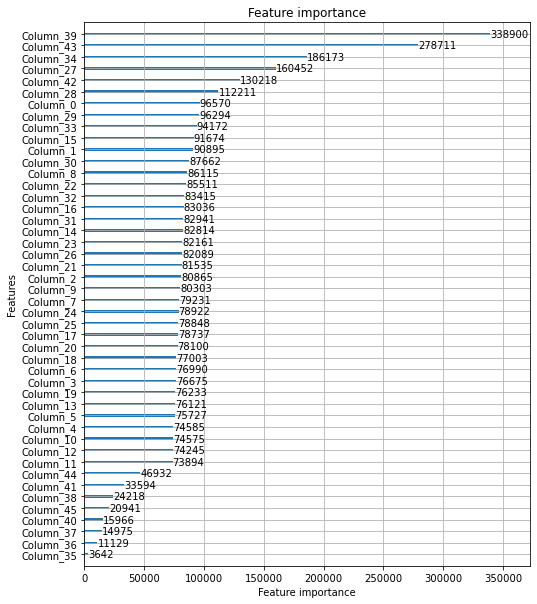

In [63]:
lgb.plot_importance(model, figsize=(8,10))

In [363]:
predictions

array([[0.87363992, 0.88076001, 0.8674595 , ..., 0.80392866, 0.88931671,
        0.96785068],
       [0.12801542, 0.21768327, 0.25947869, ..., 0.58718253, 0.73988839,
        0.75394457],
       [0.61364024, 0.61756487, 0.57133333, ..., 0.67876188, 0.9176863 ,
        0.84674448],
       ...,
       [0.76337234, 0.74738471, 0.72485069, ..., 0.94270864, 0.86811901,
        0.87433442],
       [0.89914451, 0.83169341, 0.7941819 , ..., 0.73284713, 0.913416  ,
        1.1372374 ],
       [0.45932018, 0.77602184, 1.08207415, ..., 0.86362387, 1.007293  ,
        1.09448519]])

In [352]:
np.arange(20).reshape((4,5))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [367]:
np.sum(np.square(predictions - actuals), axis = 0)

array([100019.93324995,  83367.38996016,  91031.97160793,  89281.7725182 ,
       111754.72564358, 137812.66195427, 148735.55006789, 131057.25625598,
       149678.98943148, 137090.57126126, 133787.96511714, 171787.95659446,
       193377.202348  , 179735.17123683, 175064.79215575, 124920.41921029,
       157498.65193641, 133301.93631517, 134005.2117409 , 201860.46232403,
       236577.64660356, 139264.36576748, 117248.85819343, 110172.76577734,
       114640.65986176, 124651.1363411 , 175640.15521601, 180264.41339906])

In [373]:
predictions - actuals

array([[ 0.87363992,  0.88076001,  0.8674595 , ..., -2.19607134,
         0.88931671, -0.03214932],
       [ 0.12801542, -0.78231673,  0.25947869, ...,  0.58718253,
         0.73988839,  0.75394457],
       [ 0.61364024,  0.61756487, -0.42866667, ..., -2.32123812,
         0.9176863 , -0.15325552],
       ...,
       [ 0.76337234,  0.74738471, -0.27514931, ..., -0.05729136,
         0.86811901, -1.12566558],
       [-0.10085549, -2.16830659,  0.7941819 , ..., -0.26715287,
        -0.086584  ,  1.1372374 ],
       [ 0.45932018,  0.77602184,  1.08207415, ..., -1.13637613,
        -3.992707  ,  0.09448519]])

In [374]:
modelName

'WeightedLev12_CustLoss_Recursive'

In [393]:
actuals

array([[0, 0, 0, ..., 3, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 3, 0, 1],
       ...,
       [0, 0, 1, ..., 1, 0, 2],
       [1, 3, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 2, 5, 1]])

In [ ]:
def analyzeDay(preds, day, level):
    transformed_preds = transformer[level](preds)[:, day - 1]
    transformed_actuals = transformer[level](np.array(actuals))[:, day - 1]
    return (weights[level] * np.sqrt(28) * np.abs(transformed_preds - transformed_actuals)).sum()

In [424]:
import calendar

In [425]:
calendar

<module 'calendar' from '/Users/rajatmittal/.pyenv/versions/3.7.3/lib/python3.7/calendar.py'>

In [54]:
np.save("test", [1,2,3])

In [56]:
np.load("test.npy")

array([1, 2, 3])

In [58]:
priceByDay = pd.read_csv("Other_Data/priceByDay.csv")

In [59]:
m5.weights[12]

array([9.70740759e-06, 5.11647351e-07, 2.70314355e-06, ...,
       3.30844514e-06, 1.13730592e-06, 5.81508798e-07])

In [61]:
m5.bare_revenue

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,8.38,25.14,0.00,8.38,8.38,8.38,25.14,0.00,8.38,8.38
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,3.97,0.00,0.00,0.00,0.00
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,5.94,2.97,5.94,2.97,2.97,2.97,0.00,2.97,2.97,2.97
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,4.64,0.00,23.20,18.56,4.64,0.00,4.64,13.92,32.48,9.28
4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,5.76,2.88,2.88,0.00,2.88,2.88,5.76,5.76,5.76,11.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.0,0.0,5.0,5.0,0.0,7.50,2.5,10.00,2.50,0.00,...,5.96,0.00,0.00,0.00,0.00,0.00,2.98,0.00,0.00,2.98
30486,0.0,0.0,0.0,0.0,0.0,12.35,0.0,2.47,2.47,7.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.48,0.00
30487,0.0,24.0,0.0,8.0,8.0,16.00,4.0,32.00,20.00,8.00,...,7.96,3.98,0.00,7.96,0.00,3.98,0.00,0.00,3.98,0.00
30488,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,1.28,0.00,0.00,1.28,0.00,3.84,1.28,3.84


In [76]:
priceByDay.iloc[:,2:] * df.iloc[:,6:]

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,8.38,25.14,0.00,8.38,8.38,8.38,25.14,0.00,8.38,8.38
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,3.97,0.00,0.00,0.00,0.00
2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,5.94,2.97,5.94,2.97,2.97,2.97,0.00,2.97,2.97,2.97
3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,4.64,0.00,23.20,18.56,4.64,0.00,4.64,13.92,32.48,9.28
4,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,5.76,2.88,2.88,0.00,2.88,2.88,5.76,5.76,5.76,11.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.0,0.0,5.0,5.0,0.0,7.50,2.5,10.00,2.50,0.00,...,5.96,0.00,0.00,0.00,0.00,0.00,2.98,0.00,0.00,2.98
30486,0.0,0.0,0.0,0.0,0.0,12.35,0.0,2.47,2.47,7.41,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.48,0.00
30487,0.0,24.0,0.0,8.0,8.0,16.00,4.0,32.00,20.00,8.00,...,7.96,3.98,0.00,7.96,0.00,3.98,0.00,0.00,3.98,0.00
30488,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,1.28,0.00,0.00,1.28,0.00,3.84,1.28,3.84


In [69]:
m5.bare_revenue.loc[30486, "d_6"]

12.35

In [77]:
(priceByDay.iloc[:,2:] * df.iloc[:,6:]).loc[30486, "d_6"]

12.350000000000001

In [78]:
m5.bare_revenue.to_csv("revenue.csv", index=False)

In [79]:
m5.df.to_csv("sales_train_validation.csv", index=False)

In [84]:
m5.calendar.to_csv("calendar.csv", index=False)

In [83]:
m5.full_df.to_csv("sales_train_evaluation.csv", index=False)

In [72]:
priceByDay

,item_id,store_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001,CA_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
1,HOBBIES_1_002,CA_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
2,HOBBIES_1_003,CA_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97
3,HOBBIES_1_004,CA_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64
4,HOBBIES_1_005,CA_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823,WI_3,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,...,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98
30486,FOODS_3_824,WI_3,2.47,2.47,2.47,2.47,2.47,2.47,2.47,2.47,...,2.48,2.48,2.48,2.48,2.48,2.48,2.48,2.48,2.48,2.48
30487,FOODS_3_825,WI_3,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,...,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98,3.98
30488,FOODS_3_826,WI_3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.28,1.28,1.28,1.28,1.28,1.28,1.28,1.28,1.28,1.28


In [75]:
df.iloc[:, 6:]

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
30487,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0
30488,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
